In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import hyperiax
from jax.random import PRNGKey, split
from hyperiax.execution import FastOrderedExecutor
from hyperiax.tree.fasttree import FastTree, FastBiTree
from hyperiax.models import UpLambda, DownLambda
import jax
from hyperiax.execution.collate import dict_collate
from hyperiax.tree.builders import symmetric_topology
import time
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from jax import numpy as jnp
from hyperiax.models import UpLambda, DownLambda, FuseLambda
from hyperiax.models.functional import pass_up
from hyperiax.plotting import plot_tree_2d_scatter

In [11]:
key = PRNGKey(1337)
depth = 10
print("Number of nodes:", (2<<depth)-1)

Number of nodes: 2047


In [25]:
topology = symmetric_topology(depth, 2)
tree = FastTree(topology)
#tree = FastBiTree(depth)
tree.add_property('noise', (2,))
tree.add_property('edge_length', (1,))
tree.add_property('value', (2,))

In [26]:
tree.data['edge_length'] = jnp.ones_like(tree.data['edge_length'])
tree.data['noise'] = jax.random.normal(key, tree.data['noise'].shape)
tree.data['value'] = tree.data['value'].at[0].set(tree.data['noise'][0])

In [27]:
def down(noise, edge_length,parent_value, **args):
    return {'value': jnp.sqrt(edge_length)*noise+parent_value}
downmodel = DownLambda(down_fn=down)

In [28]:
downmodel = DownLambda(down_fn=down)
exe = FastOrderedExecutor(downmodel)

In [29]:
start = time.time()
exe.down(tree);tree.data['value'].block_until_ready()
print('down', time.time()-start)

down 0.15671300888061523


KeyboardInterrupt: 

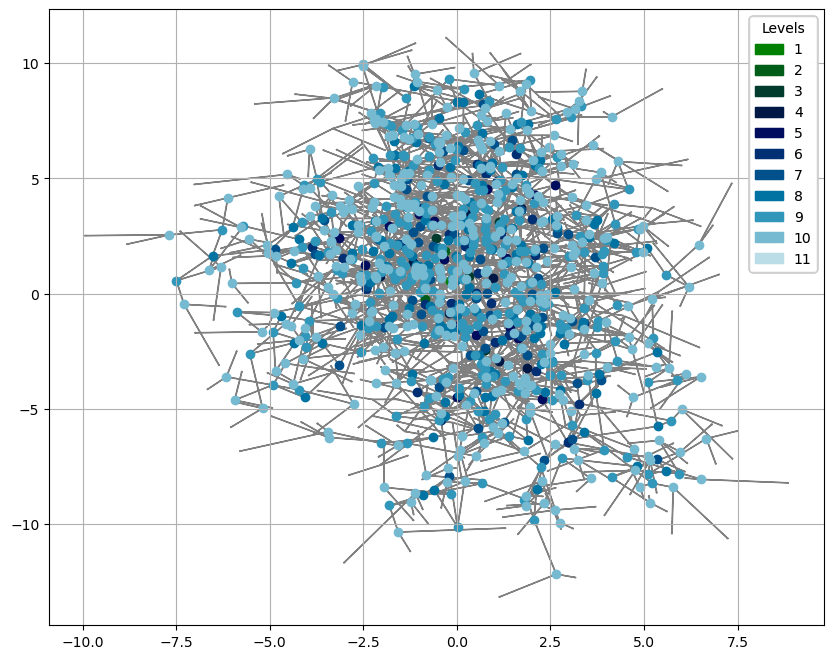

In [18]:
plot_tree_2d_scatter(tree, 'value')

In [30]:
ll1, ll2 = tree.levels[-1]

In [31]:
tree.add_property('value_est', (2,))
tree.data['value_est'] = tree.data['value_est'].at[ll1:ll2].set(tree.data['value'][ll1:ll2]) 

In [32]:
def transform(weighted_value,inverse_edge_length, **kwargs):
    return {'value_est': weighted_value/inverse_edge_length}

def up(value_est, edge_length, **kwargs):
    return {'weighted_value': value_est/edge_length, 'inverse_edge_length':1/edge_length}
upmodel = UpLambda(up, transform, 
                   reductions={
                       'weighted_value': 'sum', 
                       'inverse_edge_length': 'sum'
                    }
        )
root_exe = FastOrderedExecutor(upmodel)

In [35]:
start = time.time()
root_exe.up(tree);tree.data['value_est'].block_until_ready()
print('up', time.time()-start)

up 0.0006308555603027344


In [34]:
def fuse(child_value_est, child_edge_length, **kwargs):
    childrent_inv = 1 / child_edge_length

    result = jnp.einsum('c1,cd->d',childrent_inv, child_value_est)/childrent_inv.sum()
    return {'value': result}

In [38]:
fusemodel = FuseLambda(fuse)

In [39]:
root_exe_fuse = FastOrderedExecutor(fusemodel)